In [2]:
import os
import numpy as np
import copy
from scipy import interpolate
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
PATH = "C:/Users/maeng/desktop/lg전자 교육자료/AirQuality/AirQualityUCI.csv"

# 1. Preprocessing

In [5]:
data = pd.read_csv(PATH)
data[data == -200] = np.nan
data = data.fillna(method = "bfill")

In [6]:
name = "CO(GT)"
SIZE = 24

data = data[name]

# 2. Data Transform
#### https://towardsdatascience.com/approaching-time-series-with-a-tree-based-model-87c6d1fb6603

In [9]:
COLUMNS = ['t{}'.format(x) for x in range(SIZE)] + ['target']

time_data = []
for i in range(SIZE, data.shape[0]):
    time_data.append(data.loc[i-SIZE:i].tolist())
time_data = pd.DataFrame(time_data, columns=COLUMNS)
time_data.head()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t15,t16,t17,t18,t19,t20,t21,t22,t23,target
0,2.6,2.0,2.2,2.2,1.6,1.2,1.2,1.0,0.9,0.6,...,2.2,1.7,1.5,1.6,1.9,2.9,2.2,2.2,2.9,4.8
1,2.0,2.2,2.2,1.6,1.2,1.2,1.0,0.9,0.6,0.7,...,1.7,1.5,1.6,1.9,2.9,2.2,2.2,2.9,4.8,6.9
2,2.2,2.2,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,...,1.5,1.6,1.9,2.9,2.2,2.2,2.9,4.8,6.9,6.1
3,2.2,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,0.7,...,1.6,1.9,2.9,2.2,2.2,2.9,4.8,6.9,6.1,3.9
4,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,0.7,1.1,...,1.9,2.9,2.2,2.2,2.9,4.8,6.9,6.1,3.9,1.5


# 3. Time series components
## base-level, trend, seasonality

In [10]:
feats_data = pd.DataFrame()
feats_data['prev_1'] = time_data.iloc[:,-2] #Here -2 as -1 is a target

for win in range(3, 27, 3):
    tmp = time_data.iloc[:,-1-win:-1]
    
    #General statistics for base level
    feats_data['mean_prev_{}'.format(win)] = tmp.mean(axis=1)
    feats_data['median_prev_{}'.format(win)] = tmp.median(axis=1)
    feats_data['min_prev_{}'.format(win)] = tmp.min(axis=1)
    feats_data['max_prev_{}'.format(win)] = tmp.max(axis=1)
    feats_data['std_prev_{}'.format(win)] = tmp.std(axis=1)
    
    #Capturing trend
    feats_data['mean_ewm_prev_{}'.format(win)] = tmp.T.ewm(com=9.5).mean().T.mean(axis=1)
    feats_data['last_ewm_prev_{}'.format(win)] = tmp.T.ewm(com=9.5).mean().T.iloc[:,-1]
    
    feats_data['avg_diff_{}'.format(win)] = (tmp - tmp.shift(1, axis=1)).mean(axis=1)
    feats_data['avg_div_{}'.format(win)] = (tmp / tmp.shift(1, axis=1)).mean(axis=1)

for win in [2, 3, 4]:

    tmp = time_data.iloc[:,-1-win*6:-1:6] #7 for week
    #Features for weekly seasonality
    feats_data['6hours_mean_prev_{}'.format(win)] = tmp.mean(axis=1)
    feats_data['6hours_median_prev_{}'.format(win)] = tmp.median(axis=1)
    feats_data['6hours_min_prev_{}'.format(win)] = tmp.min(axis=1)
    feats_data['6hours_max_prev_{}'.format(win)] = tmp.max(axis=1)
    feats_data['6hours_std_prev_{}'.format(win)] = tmp.std(axis=1)

feats_data = pd.concat([feats_data, time_data.iloc[:, -1]], axis = 1)

# 4. Modeling Data

In [11]:
from sklearn.metrics import mean_squared_error as mse

train_data      = feats_data.iloc[0:8000, :]
validation_data = feats_data.iloc[8000:9000, :]
test_data       = feats_data.iloc[9000:, :]

X_train = copy.copy(train_data.iloc[:, :-1]); Y_train = copy.copy(train_data.iloc[:, -1])
X_test  = copy.copy(test_data.iloc[:, :-1]);  Y_test  = copy.copy(test_data.iloc[:, -1])

# 5. AdaBoost
#### 파라미터 참조 : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html

MSE : 1.2509170011222455


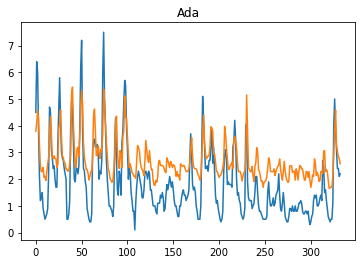

In [13]:
from sklearn.ensemble import AdaBoostRegressor

model_Ada = AdaBoostRegressor(n_estimators = 100)
model_Ada.fit(X_train, Y_train)

pred = model_Ada.predict(X_test)

plt.title("Ada")
plt.plot(Y_test.values)
plt.plot(pred)

print("MSE : " + str(mse(Y_test.values, pred)))

In [ ]:
# point = 9010
# step = 20
# COLUMNS = ['t{}'.format(x) for x in range(SIZE)]

# real = data.loc[point + 1 : point + 1 + step]
# meta = data.loc[point-SIZE + 1 : point].tolist()

# for _ in range(step):
#     test_data = pd.DataFrame(meta).T
#     test_data.columns = COLUMNS
    
#     test_feats_data = pd.DataFrame()
#     test_feats_data['prev_1'] = test_data.iloc[:,-1] #Here -2 as -1 is a target
    
#     for win in range(3, 27, 3):
#         tmp = test_data.iloc[:,-1-win:-1]
        
#         #General statistics for base level
#         test_feats_data['mean_prev_{}'.format(win)] = tmp.mean(axis=1)
#         test_feats_data['median_prev_{}'.format(win)] = tmp.median(axis=1)
#         test_feats_data['min_prev_{}'.format(win)] = tmp.min(axis=1)
#         test_feats_data['max_prev_{}'.format(win)] = tmp.max(axis=1)
#         test_feats_data['std_prev_{}'.format(win)] = tmp.std(axis=1)
        
#         #Capturing trend
#         test_feats_data['mean_ewm_prev_{}'.format(win)] = tmp.T.ewm(com=9.5).mean().T.mean(axis=1)
#         test_feats_data['last_ewm_prev_{}'.format(win)] = tmp.T.ewm(com=9.5).mean().T.iloc[:,-1]
        
#         test_feats_data['avg_diff_{}'.format(win)] = (tmp - tmp.shift(1, axis=1)).mean(axis=1)
#         test_feats_data['avg_div_{}'.format(win)] = (tmp / tmp.shift(1, axis=1)).mean(axis=1)
    
#     for win in [2, 3, 4]:
    
#         tmp = test_data.iloc[:,-1-win*6:-1:6] #7 for week
#         #Features for weekly seasonality
#         test_feats_data['6hours_mean_prev_{}'.format(win)] = tmp.mean(axis=1)
#         test_feats_data['6hours_median_prev_{}'.format(win)] = tmp.median(axis=1)
#         test_feats_data['6hours_min_prev_{}'.format(win)] = tmp.min(axis=1)
#         test_feats_data['6hours_max_prev_{}'.format(win)] = tmp.max(axis=1)
#         test_feats_data['6hours_std_prev_{}'.format(win)] = tmp.std(axis=1)
    
#     pred = model_GBM.predict(test_feats_data)[0]
    
#     meta.pop(0)
#     meta.append(pred)

# plt.plot(real.values)
# plt.plot(meta[-step:])
